# Projet 5 :  Segmentez des clients d'un site e-commerce
## Segmentation
<font color = "grey"><i> Chargement des modules necessaires </i></font>



In [1106]:
from IPython.core.display import display
from sklearn import metrics
from scipy.cluster.hierarchy import linkage
import random

from sklearn import manifold
from sklearn import decomposition
from sklearn.base import BaseEstimator
from sklearn.model_selection import ParameterGrid

from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram
from sklearn import cluster
from sklearn.metrics import silhouette_score

from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

from datetime import datetime, timedelta
from sklearn.metrics.cluster import adjusted_rand_score
import pandas as pd
import statsmodels.formula.api as smf

import statsmodels.api as sm
import plotly.graph_objects as go
import matplotlib.gridspec as gridspec
import numpy as np

import matplotlib.pyplot as plt
import statistics
import plotly.express as px

# **Importations** et chargement des données nettoyées




<font color = "grey"><i> Chargement des jeux de données  </i></font>

In [1107]:

plt.style.use('ggplot')
scaled_features = pd.read_csv("data\cleaned_p5_data.csv")
data_PCA = pd.read_csv("data\cleaned_p5_data_PCA.csv")

pd.set_option("display.max_columns", 1000)
display(data_PCA.head(2))
data_PCA.shape

,PCA_F1,PCA_F2,PCA_F3,PCA_F4,PCA_F5,PCA_F6,PCA_F7
0,2.010400,0.375303,0.609940,-0.138825,0.238363,-0.377894,-2.878553
1,2.486432,0.130351,-0.308329,-0.467694,0.728458,-0.462415,0.215830


(93162, 7)

In [1108]:
scaled_features

,payment_sequential_mean,payment_installments_mean,review_score_mean,distance_seller_customer_km,product_volume_cm3,total_price,payment_type_credit_card,customer_geolocation_region_Southeast
0,1.0,2.0,4.0,346.491931,107136.0,146.87,1,1
1,1.0,8.0,5.0,347.800921,53400.0,335.48,1,1
2,1.0,7.0,5.0,346.440279,45968.0,157.73,1,1
3,1.0,1.0,5.0,349.408210,79968.0,173.30,1,1
4,1.0,8.0,5.0,345.410141,23625.0,252.25,1,1
...,...,...,...,...,...,...,...,...
93157,1.0,6.0,4.0,368.133335,11132.0,88.78,1,1
93158,1.0,3.0,5.0,370.600934,13200.0,129.06,1,1
93159,1.0,5.0,1.0,377.888773,9000.0,56.04,1,1
93160,1.0,2.0,5.0,388.960615,3458.0,711.07,1,1


## **Échantillonage** aléatoire

In [1109]:
# Set random integer (seed)
seed = random.randrange(1000)

# Initialize the seed of "random" generator
random.seed(seed)
print("Seed value = ", seed)

Seed value =  597


In [1110]:
# Sampling from data_PCA / échantilonage
X_std = data_PCA.sample(n=2000, random_state=seed)

## **Réductions dimensionnelles** (tSNE, PCA et Isomap)

><font color = "cyan"><i> Instanciation of the embeddings </i></font>

In [1111]:
# Instanciation of t-SNE
tsne = manifold.TSNE(
    n_components=2,
    # for projection in a plane
    perplexity=30,
    n_iter=300,
    # initialisation by a PCA
    init='pca',
    random_state=0
)

# Instanciation of Isomap
isomap = manifold.Isomap(
    # for projection in a plane
    n_components=2
)

# Instanciation of PCA
pca = decomposition.PCA(
    # for projection in a plane
    n_components=2
)

# Applying the embedding algorithm
X_tsne = tsne.fit_transform(X_std)
X_isomap = isomap.fit_transform(X_std)
X_pca = pca.fit_transform(X_std)

# **Segmentation**

## **Modèle naïf :** bissection aléatoire
On considère une segmentation aléatoire en deux groupes.Qui nous donnera un score de référence (*'baseline'*).

### Évaluations avec coefficient de silhouette *s*

Coefficient de silhouetted'une segmentation :

In [1112]:
def gini(clusters_labels):
    """Compute the Gini coefficient for a clustering.
    Parameters:
        - clusters_labels:pd.Series of labels of clusters for each point.
    """

    # Get frequencies from clusters_labels
    clusters_labels = pd.Series(clusters_labels)
    frequencies = clusters_labels.value_counts()

    # Mean absolute difference
    mad = frequencies.mad()

    # Mean frequency of clusters
    mean = frequencies.mean()

    # Gini coefficient
    gini_coeff = 0.5 * mad / mean

    return gini_coeff

In [1113]:
# Initializing DataFrame of results
global results_df
results_df = pd.DataFrame()


def metrics_clustering(algorithm_name,
                       standardized_features,
                       clusters_labels,
                       results_df):
    # Number of clusters

    nb_clusters = len(set(clusters_labels)) - (1 if -1 in clusters_labels else 0)
    nb_clusters = int(nb_clusters)
    print('Estimated number of clusters (excluding noise): %d' % nb_clusters)
    results_df.loc[algorithm_name, 'Nb of clusters'] = nb_clusters

    # Silhouette score

    silhouette = metrics.silhouette_score(
        standardized_features,
        clusters_labels
    )
    print("\nSilhouette coefficient: s = {:.3f}".format(silhouette))
    print("  Notice: values closer to 1 indicate a better partition")
    results_df.loc[algorithm_name, 'Silhouette'] = silhouette

    # Gini coefficient

    gini_coeff = gini(clusters_labels)
    print("\nGini coefficient: G = {:.3f}".format(gini_coeff))
    print("  Notice: values closer to 0 indicate \
    homogenic frequencies for clusters.")
    results_df.loc[algorithm_name, 'Gini'] = gini_coeff

    # Sorting the pd.DataFrame of results
    results_df = results_df.sort_values('Silhouette', ascending=False)

    return results_df

In [1114]:


algorithm_name = 'Naïve model'
standardized_features = X_std

# Random labels (0 or 1)
clusters_labels = np.random.randint(2, size=len(standardized_features))

metrics_clustering(
    algorithm_name,
    standardized_features,
    clusters_labels,
    results_df
)

Estimated number of clusters (excluding noise): 2

Silhouette coefficient: s = 0.000
  Notice: values closer to 1 indicate a better partition

Gini coefficient: G = 0.002
  Notice: values closer to 0 indicate     homogenic frequencies for clusters.


,Nb of clusters,Silhouette,Gini
Naïve model,2.0,0.000154,0.002


## **Ségmentation hiérarchique** (*hierarchical clustering*)

In [1115]:

global SelectedModel
class GridSearch(BaseEstimator):
    """Classe permettant d'implémenter une recherche exhaustive sur grille
    (sans validation croisée) pour les algorithmes de clustering."""

    # Method: init
    # ------------------------------------------------------------------------------
    def __init__(
            self,
            estimator,  # clustering algorithm to test
            param_grid,  # research space for hyperparameters
            scoring=None):
        """Méthode d'initialisation prenant en entrée le modèle
        à tester et la grille de paramètres."""

        # getting parameters
        self.estimator = estimator
        self.param_grid = param_grid
        self.scoring = scoring

    # Method: fit
    # ------------------------------------------------------------------------------
    def fit(self, X):
        """Méthode permettant de réaliser la recherche sur grille,
        et renvoyant le meilleur modèle trouvé, ré-entraîné sur les données."""

        # initialization of the dict of results
        self.results_ = {"scores": [],
                         "params": [],
                         "models": [],
                         "fit_times": [],
                         "nb_clusters": [],
                         "gini_coef": []}




        # iterating upon all combinations of parameters
        for param_combination in ParameterGrid(param_grid):

            # instanciation of the model with selected parameters
            model = self.estimator(**param_combination)
            SelectedModel = model
            # Measuring training time while fitting the model on the data
            time_train = %timeit -n1 -r1 -o -q model.fit(X)
            time_train = time_train.average

            # Scoring the model
            if not self.scoring:  # if scoring parameter not defined
                model_score = model.score(X)
            else:  # if scoring parameter is defined
                try:
                    labels = model.labels_
                    model_score = self.scoring(X, labels)
                except:
                    model_score = np.nan

            # Computing number of clusters, excluding noise (#-1)
            nb_clusters = \
                len(set(model.labels_)) - (1 if -1 in clusters_labels else 0)
            nb_clusters = int(nb_clusters)

            # Computing Gini coefficient
            gini_coeff = gini(model.labels_)

            # saving results, parameters and models in a dict
            self.results_["scores"].append(model_score)  # scores
            self.results_["params"].append(param_combination)  # parameters
            self.results_["models"].append(model)  # trained models
            self.results_["fit_times"].append(time_train)  # training time
            self.results_["gini_coef"].append(gini_coeff)  # Gini coefficient
            self.results_["nb_clusters"].append(nb_clusters)  # nb of clusters

        # Selecting best model (assumes that 'greater is better')
        # -----------------------------------
        best_model_index, best_score = None, None  # initialisation
        # iterating over scores
        for index, score in enumerate(self.results_["scores"]):

            # initialisation
            if not best_score:
                best_score = score
                best_model_index = index

            # if score is better than current best_score
            if score > best_score:
                # update the current best_score and current best_model_index
                best_score = score
                best_model_index = index

        # Update attributes of the instance
        self.best_score_ = self.results_["scores"][best_model_index]
        self.best_params_ = self.results_["params"][best_model_index]
        self.best_estimator_ = self.results_["models"][best_model_index]
        self.best_index_ = best_model_index
        self.refit_time_ = self.results_["fit_times"][best_model_index]

        return self

    # Method: predict
    # ------------------------------------------------------------------------------
    def predict(self, X_test):
        """Méthode permettant de réaliser les prédictions sur le jeu de test,
        en utilisant le meilleur modèle trouvé avec la méthode .fit
        entraîné sur le jeu d'entraînement complet."""

        # use the .predict method of the estimator on the best model
        return self.best_model.predict(X_test)

### Définition de l'espace de recherche

In [1116]:


# Definition of the search space for hyperparameters
param_grid = [
    {
        # number of clusters to find
        'n_clusters': range(4, 10),
        # linkage criterion to use
        'linkage': ['complete', 'average', 'single'],
        # Metric used to compute the linkage
        'affinity': ['euclidean', 'manhattan', 'cosine']
    },

    {
        'n_clusters': range(4, 10),  # number of clusters to find
        'linkage': ['ward'],  # linkage criterion to use
    }
]

### Sélection des hyper-paramètres

In [1117]:





# instanciation of the GridSearch object
hierarchy_search = GridSearch(
    estimator=AgglomerativeClustering,
    param_grid=param_grid,
    scoring=silhouette_score,
)

# Proceeding the grid search
hierarchy_search.fit(X_std)

# Displays best parameters
print("Best hyperparameters:", hierarchy_search.best_params_)
print("Best Silhouette score:", hierarchy_search.best_score_)
print("Training time:", hierarchy_search.refit_time_)

Best hyperparameters: {'affinity': 'manhattan', 'linkage': 'average', 'n_clusters': 4}
Best Silhouette score: 0.7871147749323605
Training time: 0.11208690000057686


In [1118]:
pd.DataFrame(hierarchy_search.results_)

,scores,params,models,fit_times,nb_clusters,gini_coef
0,0.580182,"{'affinity': 'euclidean', 'linkage': 'complete...","AgglomerativeClustering(linkage='complete', n_...",0.144682,4,0.732500
1,0.580007,"{'affinity': 'euclidean', 'linkage': 'complete...","AgglomerativeClustering(linkage='complete', n_...",0.124858,5,0.782500
2,0.579126,"{'affinity': 'euclidean', 'linkage': 'complete...","AgglomerativeClustering(linkage='complete', n_...",0.124050,6,0.815833
3,0.541793,"{'affinity': 'euclidean', 'linkage': 'complete...","AgglomerativeClustering(linkage='complete', n_...",0.124451,7,0.835643
4,0.236996,"{'affinity': 'euclidean', 'linkage': 'complete...","AgglomerativeClustering(linkage='complete', n_...",0.124670,8,0.728500
5,0.199257,"{'affinity': 'euclidean', 'linkage': 'complete...","AgglomerativeClustering(linkage='complete', n_...",0.123995,9,0.725778
6,0.707978,"{'affinity': 'euclidean', 'linkage': 'average'...","AgglomerativeClustering(linkage='average', n_c...",0.124686,4,0.743000
7,0.681799,"{'affinity': 'euclidean', 'linkage': 'average'...","AgglomerativeClustering(linkage='average', n_c...",0.123313,5,0.793000
8,0.581898,"{'affinity': 'euclidean', 'linkage': 'average'...","AgglomerativeClustering(linkage='average', n_c...",0.124781,6,0.821833
9,0.581584,"{'affinity': 'euclidean', 'linkage': 'average'...","AgglomerativeClustering(linkage='average', n_c...",0.120630,7,0.845643


### Dendrogramme avec Scipy


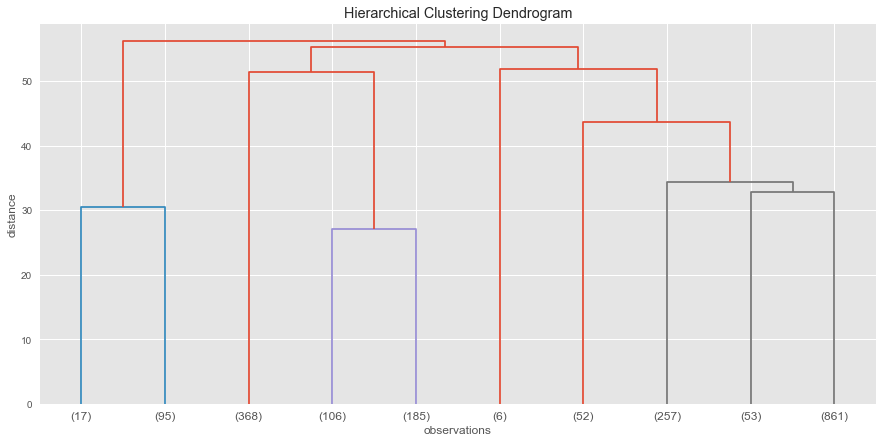

In [1119]:




def plot_dendrogram(Z, labels=[], p=10):
    """This function plots the dendogram.
    Parameters:
    ----------
        - Z : linkage. Ex:Z = linkage(X_std, 'ward')
        - labels : names of the points
        - p : numbers of clusters to stop"""



    plt.figure(figsize=(15, 7))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('observations')
    plt.ylabel('distance')
    dendrogram(
        Z,
        p=p,
        # labels = names,
        truncate_mode="lastp"
    )
    plt.show()


# Clustering hiérarchique (critère de Ward)
Z = linkage(X_std, 'ward')

# number of clusters for truncating dendogram
p = 10

# plotting the dendogram
plot_dendrogram(Z, p=p)

### Visualisation par réduction dimensionnelle

In [1120]:



def plot_clusters(
        standardized_features,
        clusters_labels,
        embedding_algo='tSNE',
        ax=None):
    """
    Arguments:
    ---------
    embedding_algo: 'tSNE' or 'PCA' or 'Isomap'
    """

    # Applying the embedding


    # Instanciation of the embedding
    if embedding_algo == 'tSNE':
        X_projected = X_tsne

    elif embedding_algo == 'Isomap':
        X_projected = X_isomap

    elif embedding_algo == 'PCA':
        X_projected = X_pca

    # Plotting the Isomap embedding
    # -----------------------------

    # If no axes is passed…
    if not ax:
        # Set the axes to the current one
        ax = plt.gca()  # ax = ax or plt.gca()
        # Set dimensions of the figure (if no axes is passed)
        plt.gcf().set_figwidth(12)
        plt.gcf().set_figheight(7)

    # Definitions of axis boundaries
    ax.set_xlim(X_projected[:, 0].min() * 1.1, X_projected[:, 0].max() * 1.1)
    ax.set_ylim(X_projected[:, 1].min() * 1.1, X_projected[:, 1].max() * 1.1)

    # Properties of the axes
    ax.set_title(embedding_algo, fontsize=20)

    if embedding_algo == 'PCA':
        # Names of x- and y- axis, with percentage of explained variance
        ax.set_xlabel('First component ({}%)'
                      .format(round(100 * pca.explained_variance_ratio_[0], 1)))
        ax.set_ylabel('Second component ({}%)'
                      .format(round(100 * pca.explained_variance_ratio_[1], 1)))
    else:
        ax.set_xlabel('First component')
        ax.set_ylabel('Second component')

    # Setting color
    NB_CLUSTERS = len(set(clusters_labels)) - (1 if -1 in clusters_labels else 0)
    color = clusters_labels / NB_CLUSTERS

    # Setting color to black for noise points
    # color = pd.Series(clusters_labels / NB_CLUSTERS).astype('object')
    # color = color.map(lambda x: x if x != (-1 / NB_CLUSTERS) else 'black')

    # Plotting the scatter plot
    ax.scatter(
        X_projected[:, 0],  # x-coordinate
        X_projected[:, 1],  # y-coordinate
        c=color,  # base for coloration of points
        cmap=plt.cm.get_cmap('Set1'),  # colormap
    )


In [1121]:



def clustering_plots(algorithm_name, standardized_features, clusters_labels):
    fig = plt.figure()

    # Set properties of the figure
    fig.set_figheight(6)
    fig.set_figwidth(23)
    fig.suptitle('Visualisation of clustering with {}'
                 .format(algorithm_name), fontsize=20)

    # Set the geometry of the grid of subplots
    gs = gridspec.GridSpec(nrows=1, ncols=3, )

    # Initialize axes and set position (left to right, top to bottom)
    # Use sharex or sharey parameter for sharing axis
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    ax3 = fig.add_subplot(gs[2])

    # Filling the axes
    plot_clusters(
        standardized_features,
        clusters_labels,
        embedding_algo='tSNE',
        ax=ax1
    )
    plot_clusters(
        standardized_features,
        clusters_labels,
        embedding_algo='PCA',
        ax=ax2
    )
    plot_clusters(
        standardized_features,
        clusters_labels,
        embedding_algo='Isomap',
        ax=ax3
    )

    # Automatically adjusts subplots params to fit the figure
    gs.tight_layout(fig, rect=[0, 0, 1, 0.96])

    fig.savefig('visualisation/tsne_pca_first.png')

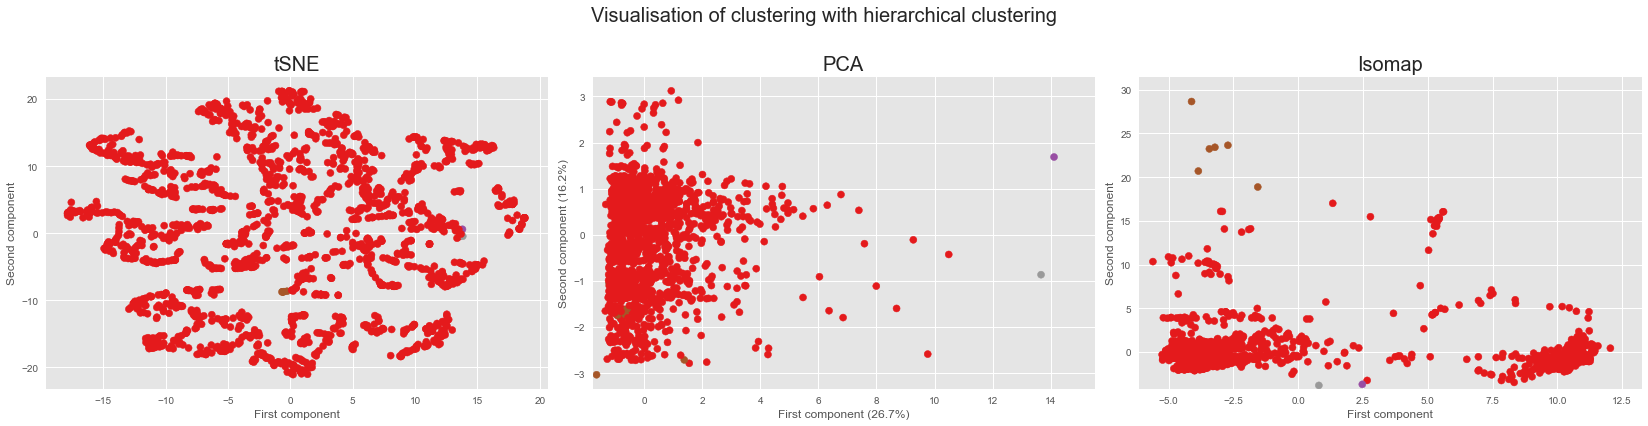

In [1122]:


# Setup for call to the clustering_plots function
algorithm_name = 'hierarchical clustering'
standardized_features = X_std
clusters_labels = hierarchy_search.best_estimator_.labels_

clustering_plots(algorithm_name, standardized_features, clusters_labels)

### Évaluation de la partition

In [1123]:


# Computes and displays results
metrics_clustering(
    algorithm_name,
    standardized_features,
    clusters_labels,
    results_df
)

Estimated number of clusters (excluding noise): 4

Silhouette coefficient: s = 0.787
  Notice: values closer to 1 indicate a better partition

Gini coefficient: G = 0.746
  Notice: values closer to 0 indicate     homogenic frequencies for clusters.


,Nb of clusters,Silhouette,Gini
hierarchical clustering,4.0,0.787115,0.746
Naïve model,2.0,0.000154,0.002


## ***k-MEANS***

### Définition de l'espace de recherche des hyper-paramètres

In [1124]:


# Definition of the search space for hyperparameters
param_grid = {
    "n_clusters": range(2, 11),  # number of clusters
}

### Application de l'algorithme et ajustement des hyper-paramètres

In [1125]:





# instanciation of the GridSearch object
kmeans_search = GridSearch(
    estimator=cluster.MiniBatchKMeans,
    param_grid=param_grid,
    scoring=silhouette_score,
)

# Proceeding the grid search
kmeans_search.fit(X_std)

# Displays best parameters
print("Best hyperparameters:", kmeans_search.best_params_)
print("Best Silhouette score:", kmeans_search.best_score_)
print("Training time:", kmeans_search.refit_time_)

Best hyperparameters: {'n_clusters': 8}
Best Silhouette score: 0.3593549145777089
Training time: 0.061463199999707285


### Influence des hyper-paramètres

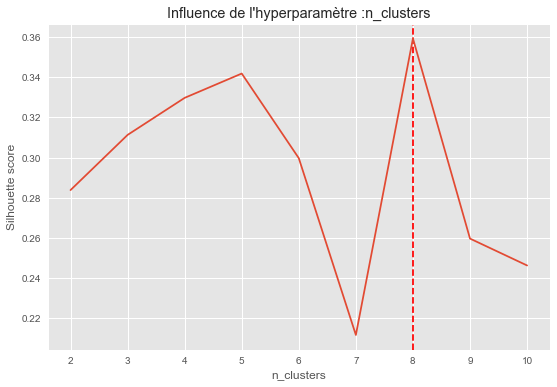

In [1126]:




# Getting the list of parameters and list of scores
n_clusters_list = [kmeans_search.results_['params'][i]['n_clusters']
                   for i in range(len(kmeans_search.results_['params']))]
scores_list = kmeans_search.results_['scores']

# Plotting the influence of the single hyperparameter
x = n_clusters_list
y = scores_list
plt.xlabel("n_clusters")
plt.ylabel("Silhouette score")
plt.title("Influence de l'hyperparamètre :n_clusters")
plt.axvline(x=kmeans_search.best_params_['n_clusters'], color='red', linestyle='--')
plt.plot(x, y)


In [ ]:


plt.rcParams["figure.figsize"] = (9, 6)
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4, 15))

X = data_PCA.values

visualizer.fit(X)
visualizer.poof()

In [ ]:
visualizer = SilhouetteVisualizer(model)
visualizer.fit(X)
visualizer.poof()

In [ ]:
# Silhouette Score for K means
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2, 30), metric='silhouette', timings=True)
visualizer.fit(X)  # Fit the data to the visualizer
visualizer.show()

### Réduction dimensionnelle et visualisation

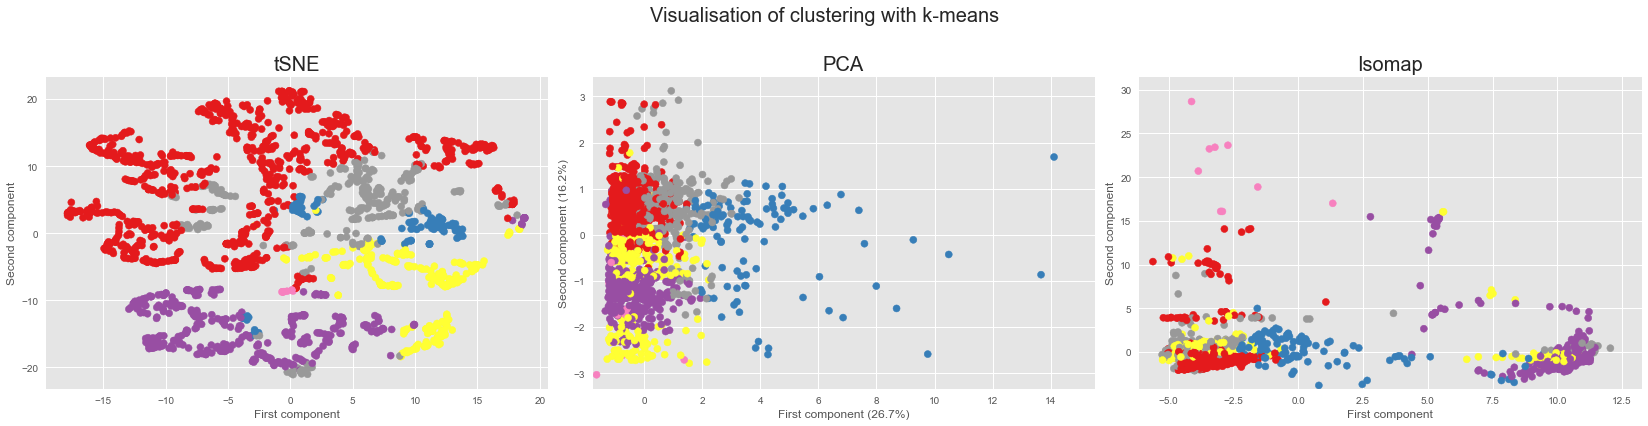

In [1127]:

kmeans = cluster.MiniBatchKMeans(n_clusters=6, random_state=seed)
kmeans.fit(X_std)
model_kmean = kmeans
# Setup for call to the clustering_plots function
algorithm_name = 'k-means'
standardized_features = X_std
clusters_labels = kmeans.labels_
SelectedModel.fit(X_std)

clustering_plots(algorithm_name, standardized_features, clusters_labels)

### Évaluation de la partition

In [1128]:
# Computes and displays results
metrics_clustering(algorithm_name, standardized_features,
                   clusters_labels, results_df
                   )



Estimated number of clusters (excluding noise): 6

Silhouette coefficient: s = 0.321
  Notice: values closer to 1 indicate a better partition

Gini coefficient: G = 0.338
  Notice: values closer to 0 indicate     homogenic frequencies for clusters.


,Nb of clusters,Silhouette,Gini
hierarchical clustering,4.0,0.787115,0.746000
k-means,6.0,0.320811,0.338167
Naïve model,2.0,0.000154,0.002000


# **Profilage** des catégories de clients

## Récupération des informations

In [1129]:
model = kmeans  # k-means 'handmade'

In [1130]:

# Getting the original standardized features for customers
standardized_features = pd.read_csv("data\cleaned_p5_data_std.csv")

In [1131]:
standardized_features.head(2)

,payment_sequential_mean,payment_installments_mean,review_score_mean,distance_seller_customer_km,product_volume_cm3,total_price,payment_type_credit_card,customer_geolocation_region_Southeast
0,-0.12058,-0.336493,-0.050546,-0.17144,3.953368,0.001150,0.586052,0.004633
1,-0.12058,1.903894,0.687897,-0.16829,1.642647,0.953101,0.586052,0.004633


In [1132]:
# Re-fitting the algorithm
model.fit(X_std)
clusters_labels = model.labels_

# Creating a mask for the sample
mask = standardized_features.index.isin(X_std.index)

# Keeping data only for the sample
standardized_features = standardized_features[mask]

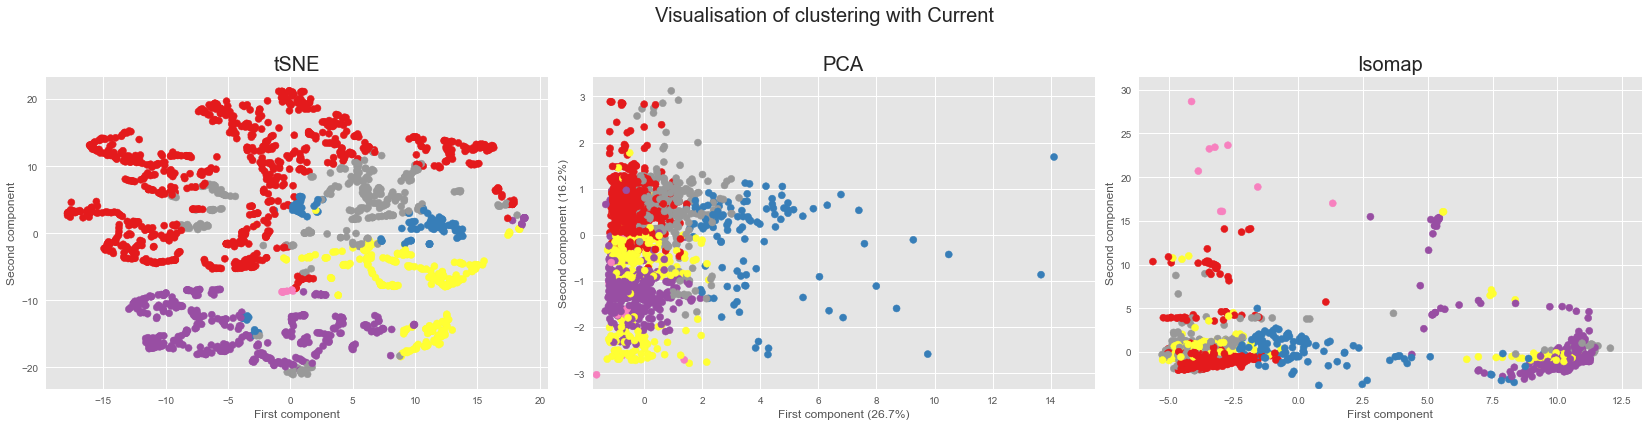

In [1133]:

# Embedding by tSNE, PCA and Isomap
clustering_plots(
    algorithm_name='Current',
    standardized_features=X_std,
    clusters_labels=model.labels_
)

In [1134]:


# Convert labels to pandas.DataFrame
clusters_labels = pd.Series(clusters_labels)
clusters_labels = clusters_labels.to_frame('cluster_labels')

# Get the list of clusters
list_clusters = clusters_labels['cluster_labels'].unique()
list_clusters.sort()

# Display frequencies for clusters
clusters_labels['cluster_labels'].value_counts(normalize=True, sort=False)

0    0.4690
1    0.0545
2    0.2025
3    0.1290
4    0.0045
5    0.1405
Name: cluster_labels, dtype: float64

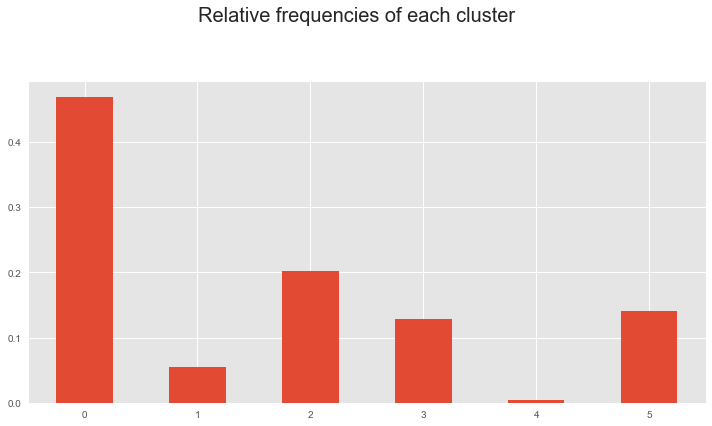

In [1135]:
fig = plt.figure()

# Set properties of the figure
fig.set_figheight(6)
fig.set_figwidth(10)
fig.suptitle('Relative frequencies of each cluster', fontsize=20)

# Set the geometry of the grid of subplots
gs = gridspec.GridSpec(nrows=1, ncols=1, )

# Initialize axes and set position (left to right, top to bottom)
# Use sharex or sharey parameter for sharing axis
ax1 = fig.add_subplot(gs[0])

# Filling the axes
labels_counts = clusters_labels['cluster_labels'].value_counts().sort_index() / len(clusters_labels)
labels_counts.plot.bar(ax=ax1)

# Rotation of ticks labels
plt.setp(ax1.get_xticklabels(), rotation='horizontal')

# Automatically adjusts subplots params to fit the figure
gs.tight_layout(fig, rect=[0, 0, 1, 0.9])

fig.savefig('visualisation/clusters_frequencies.png')

## **Ré-échelonnage** des valeurs (0 à 100)

In [1136]:



# Rescale the features from 0 to 100
scaler = MinMaxScaler(feature_range=(0, 100))
scaled_features = scaler.fit_transform(standardized_features)

# Convert back to a pd.DataFrame
features_names = standardized_features.columns
scaled_features = pd.DataFrame(scaled_features, columns=features_names)

## **Significativité** des variables (méthode ANOVA)
Nous testons l'exitence d'une dépendance entre chacune des variables (considérées individuellements) et le groupe (variable qualitative).



In [1137]:


def get_significant_features(dataframe, categorical_labels, threshold=0.05):
    """This function proceed to a "1 variable - ANOVA" test
    for each feature in the dataframe and returns a list
    of p-values for the Fischer statistic."""




    # categorical feature (labels) to test against
    clusters_labels = categorical_labels

    # initialize pd.DataFrame for results
    results_anova = pd.DataFrame()

    # create a pd.DataFrame with features and labels
    data_anova = pd.concat([dataframe, clusters_labels], axis=1)

    # iterating of features
    for feature_name in dataframe.columns:
        # create the model for the "1-variable ANOVA"
        formula = feature_name + "~" + "cluster_labels"
        anova_feature = smf.ols(formula, data=data_anova).fit()

        # get the p-value for the test statistic (Fisher)
        p_value = sm.stats.anova_lm(anova_feature, typ=2)['PR(>F)'][0]

        # Save the p-value for the test in a pd.DataFrame
        results_anova.loc[feature_name, 'p-value'] = p_value
        results_anova.loc[feature_name, 'significant'] = (p_value < threshold)

    # return pd.DataFrame of results
    return results_anova

In [1138]:
# Setup before calling the function
dataframe = scaled_features
categorical_labels = clusters_labels

# Proceed to the "1 variable ANOVA test"
results_anova = get_significant_features(
    dataframe,
    categorical_labels,
    threshold=0.05
)

# Displays result of ANOVA analysis
display(results_anova)

# Get the significant features(above threshold)
threshold = 0.05
mask = (results_anova['p-value'] < threshold)
significant_features = results_anova[mask].index

c:\users\marj1\pycharmprojects\project5\env\lib\site-packages\statsmodels\base\model.py:1863: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0

c:\users\marj1\pycharmprojects\project5\env\lib\site-packages\statsmodels\base\model.py:1881: RuntimeWarning:

invalid value encountered in true_divide



,p-value,significant
payment_sequential_mean,0.590853,False
payment_installments_mean,0.600969,False
review_score_mean,0.314169,False
distance_seller_customer_km,0.582679,False
product_volume_cm3,0.746377,False
total_price,0.599735,False
payment_type_credit_card,0.077113,False
customer_geolocation_region_Southeast,NaN,False


In [1139]:

# Keep  significant features for Kiviat diagrams
mask_features = scaled_features.columns.isin(significant_features)
scaled_features = scaled_features.loc[:, mask_features]

# Display head of remaining data
scaled_features.head(3)

""
0
1
2


## **Agrégation** des caractéristiques

In [1140]:

# Get the name of features
features_names = scaled_features.columns

# Initializing a pd.DataFrame to store aggregate values
clusters_agg_df = pd.DataFrame(
    columns=[feature_name for feature_name in features_names]
)

# Iterating upon clusters
for cluster_index in list_clusters:

    # Getting elements of the cluster
    mask = (clusters_labels['cluster_labels'] == cluster_index)

    # For each feature. Could be vectorized.
    for feature in scaled_features.columns:
        # compute the mean
        mean_of_feature_for_cluster = scaled_features[mask][feature].mean()
        clusters_agg_df.loc[cluster_index, feature] = mean_of_feature_for_cluster
        # compute the standard deviation
        std_of_feature_for_cluster = scaled_features[mask][feature].std()
        clusters_agg_df.loc[cluster_index, feature + '_std'] = std_of_feature_for_cluster

# Compute the data for the 'mean customer'
for feature in scaled_features.columns:
    # compute the mean
    mean_of_feature = scaled_features[feature].mean()
    clusters_agg_df.loc['mean customer', feature] = mean_of_feature
    # compute the standard deviation
    std_of_feature = scaled_features[feature].std()
    clusters_agg_df.loc['mean customer', feature + '_std'] = std_of_feature
    # compute the standard deviation
    median_of_feature = scaled_features[feature].median()
    clusters_agg_df.loc['median customer', feature] = median_of_feature

clusters_agg_df.head(10)

""


## Séparer les données **catégorielles**

In [1141]:


# Listing the categorical features encoded
categorical_features = [
    'main_cat_furniture',
    'main_cat_home',
    'main_cat_sports_leisure',
    'main_cat_electronics',
    'main_cat_fashion',
    'main_cat_supplies',
    'main_cat_health_beauty',
    'main_cat_construction',
    'main_cat_misc',
    'main_cat_gifts',
    'main_cat_food_drink',
]

# Masking columns based on their name
mask = clusters_agg_df.columns.isin(categorical_features)
data_kiviat = clusters_agg_df.loc[:, ~mask]
numerical_features = set(features_names) - set(categorical_features)

In [1142]:
print(numerical_features)


set()


In [1143]:
# Get features names
features_names = list(numerical_features)

# Get number of variables
num_vars = len(features_names)
cluster_index



5

In [1144]:
radar = data_kiviat
categories = ['payment sequential mean', 'payment installments mean', 'review score mean',
              'distance seller customer km',
              'product volume cm3', 'total price', 'payment type credit card', 'customer geolocation region Southeast']


In [1145]:



scaled_features = pd.read_csv("data\cleaned_p5_data.csv")

In [1146]:
model.fit(scaled_features)

clusters = model.labels_

In [1147]:
clusters




array([3, 5, 5, ..., 4, 1, 1])

In [1148]:
pca = decomposition.PCA(n_components=2).fit(scaled_features)
X_projected = pca.transform(scaled_features)

centroids = model.cluster_centers_


In [1149]:
centroids_projected = pca.transform(centroids)


In [1150]:
Radar_cluster = scaled_features.copy()

Radar_cluster['Cluster Labels'] = clusters

Radar_cluster.head(2)

Radar_cluster['Segment'] = Radar_cluster['Cluster Labels'].map({0: 'Cluster 1', 1: 'Cluster 2',
                                                                2: 'Cluster 3', 3: 'Cluster 4',
                                                                4: 'Cluster 5', 5: 'Cluster 6',
                                                                6: 'Cluster 7', 7: 'Cluster 8', 8: 'Cluster 9',
                                                                # 9:'Cluster 10'
                                                                })
Radar_cluster

,payment_sequential_mean,payment_installments_mean,review_score_mean,distance_seller_customer_km,product_volume_cm3,total_price,payment_type_credit_card,customer_geolocation_region_Southeast,Cluster Labels,Segment
0,1.0,2.0,4.0,346.491931,107136.0,146.87,1,1,3,Cluster 4
1,1.0,8.0,5.0,347.800921,53400.0,335.48,1,1,5,Cluster 6
2,1.0,7.0,5.0,346.440279,45968.0,157.73,1,1,5,Cluster 6
3,1.0,1.0,5.0,349.408210,79968.0,173.30,1,1,3,Cluster 4
4,1.0,8.0,5.0,345.410141,23625.0,252.25,1,1,0,Cluster 1
...,...,...,...,...,...,...,...,...,...,...
93157,1.0,6.0,4.0,368.133335,11132.0,88.78,1,1,4,Cluster 5
93158,1.0,3.0,5.0,370.600934,13200.0,129.06,1,1,4,Cluster 5
93159,1.0,5.0,1.0,377.888773,9000.0,56.04,1,1,4,Cluster 5
93160,1.0,2.0,5.0,388.960615,3458.0,711.07,1,1,1,Cluster 2


In [1151]:
Radar_cluster['Segment'].value_counts()
df_count_clu = pd.DataFrame({'Segment': Radar_cluster['Segment'].value_counts().index,
                            'Nombre': Radar_cluster['Segment'].value_counts().values})
df_count_clu

,Segment,Nombre
0,Cluster 2,47618
1,Cluster 5,22821
2,Cluster 1,14434
3,Cluster 6,5878
4,Cluster 4,2026
5,Cluster 3,385


In [1152]:
Radar_cluster['Segment'] = Radar_cluster['Segment'].astype('category')
Radar_cluster['Segment'] = Radar_cluster['Segment'].cat.reorder_categories(['Cluster 1',
                                                                            'Cluster 2',
                                                                            'Cluster 3',
                                                                            'Cluster 4',
                                                                            'Cluster 5',
                                                                            'Cluster 6',
                                                                            #'Cluster 7','Cluster 8','Cluster 9',
                                                                            # 'Cluster 10'
                                                                            ])

Radar_cluster.head()
Ref_Radar_cluster = Radar_cluster

In [1153]:
Radar_cluster = Radar_cluster.groupby('Segment').agg(payment_sequential_mean=('payment_sequential_mean', 'mean'),
                                                     payment_installments_mean=('payment_installments_mean', 'mean'),
                                                     review_score_mean=('review_score_mean', 'mean'),
                                                     distance_seller_customer_km=(
                                                         'distance_seller_customer_km', 'mean'),
                                                     product_volume_cm3=('product_volume_cm3', 'mean'),
                                                     total_price=('total_price', 'mean'),
                                                     payment_type_credit_card=('payment_type_credit_card', 'mean'),
                                                     customer_geolocation_region_Southeast=(
                                                         'customer_geolocation_region_Southeast', 'mean'))

#payment_sequential_mean	payment_installments_mean	review_score_mean	distance_seller_customer_km	product_volume_cm3	total_price	payment_type_credit_card	customer_geolocation_region_Southeast	Cluster Labels	Segment
Radar_cluster

,payment_sequential_mean,payment_installments_mean,review_score_mean,distance_seller_customer_km,product_volume_cm3,total_price,payment_type_credit_card,customer_geolocation_region_Southeast
Segment,,,,,,,,
Cluster 1,1.025872,3.338628,4.071281,415.686446,27316.020531,171.457130,0.739643,1.000000
Cluster 2,1.020110,2.532264,4.106891,417.062740,3109.725011,112.760029,0.745579,0.999979
Cluster 3,1.042857,5.562338,3.821150,418.945342,203152.349351,779.726203,0.727273,1.000000
Cluster 4,1.044669,4.584375,3.858575,425.780093,102057.224665,405.169383,0.760118,1.000000
Cluster 5,1.026419,2.970586,4.020469,420.116212,11608.649305,141.659876,0.744008,0.999956
Cluster 6,1.022274,3.791430,4.024890,416.080692,55088.830559,248.958109,0.742940,1.000000


In [1154]:
#MinMax_scale = preprocessing.MinMaxScaler(feature_range=(0, 100)).fit(Radar_cluster.values)
#Radar_cluster = MinMax_scale.transform(Radar_cluster.values)
MinMax_scale = preprocessing.MinMaxScaler(feature_range=(0, 100)).fit(Radar_cluster.values)
scaled_features = MinMax_scale.transform(Radar_cluster.values)
# Convert back to a pd.DataFrame
features_names = standardized_features.columns
Radar_cluster = pd.DataFrame(scaled_features, columns=features_names)

In [1155]:
fig = go.Figure()

fig.add_trace(go.Scatterpolar(
    r=[Radar_cluster['payment_sequential_mean'][0], Radar_cluster['payment_installments_mean'][0],
       Radar_cluster['review_score_mean'][0], Radar_cluster['distance_seller_customer_km'][0],
       Radar_cluster['product_volume_cm3'][0], Radar_cluster['total_price'][0],
       Radar_cluster['payment_type_credit_card'][0], Radar_cluster['customer_geolocation_region_Southeast'][0]],
    theta=categories,
    fill='toself',
    name='Cluster 1: Dépense très peu mais satisfait  '
))
fig.add_trace(go.Scatterpolar(
    r=[Radar_cluster['payment_sequential_mean'][1], Radar_cluster['payment_installments_mean'][1],
       Radar_cluster['review_score_mean'][1], Radar_cluster['distance_seller_customer_km'][1],
       Radar_cluster['product_volume_cm3'][1], Radar_cluster['total_price'][1],
       Radar_cluster['payment_type_credit_card'][1], Radar_cluster['customer_geolocation_region_Southeast'][1]],
    theta=categories,
    fill='toself',
    name='Cluster 2: Acheteur par carte de crédit avec moyen crédit et très satisfait '
))
fig.add_trace(go.Scatterpolar(
    r=[Radar_cluster['payment_sequential_mean'][2], Radar_cluster['payment_installments_mean'][2],
       Radar_cluster['review_score_mean'][2], Radar_cluster['distance_seller_customer_km'][2],
       Radar_cluster['product_volume_cm3'][2], Radar_cluster['total_price'][2],
       Radar_cluster['payment_type_credit_card'][2], Radar_cluster['customer_geolocation_region_Southeast'][1]],
    theta=categories,
    fill='toself',
    name='Cluster 3: Client satifait mais éloigné: Paiement par carte de credit et en plusieurs fois pour de petite somme '
))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=False,
            range=[0, 100]
        )),
    title="Radar Chart des Clusters 1, 2, 3",
    showlegend=True
)
fig.show()

In [1156]:
fig = go.Figure()

fig.add_trace(go.Scatterpolar(
    r=[Radar_cluster['payment_sequential_mean'][0], Radar_cluster['payment_installments_mean'][0],
       Radar_cluster['review_score_mean'][0], Radar_cluster['distance_seller_customer_km'][0],
       Radar_cluster['product_volume_cm3'][0], Radar_cluster['total_price'][0],
       Radar_cluster['payment_type_credit_card'][0], Radar_cluster['customer_geolocation_region_Southeast'][0]],
    theta=categories,
    fill='toself',
    name='Cluster 1: '
))
fig.add_trace(go.Scatterpolar(
    r=[Radar_cluster['payment_sequential_mean'][1], Radar_cluster['payment_installments_mean'][1],
       Radar_cluster['review_score_mean'][1], Radar_cluster['distance_seller_customer_km'][1],
       Radar_cluster['product_volume_cm3'][1], Radar_cluster['total_price'][1],
       Radar_cluster['payment_type_credit_card'][1], Radar_cluster['customer_geolocation_region_Southeast'][1]],
    theta=categories,
    fill='toself',
    name='Cluster 2: '
))
fig.add_trace(go.Scatterpolar(
    r=[Radar_cluster['payment_sequential_mean'][2], Radar_cluster['payment_installments_mean'][2],
       Radar_cluster['review_score_mean'][2], Radar_cluster['distance_seller_customer_km'][2],
       Radar_cluster['product_volume_cm3'][2], Radar_cluster['total_price'][2],
       Radar_cluster['payment_type_credit_card'][2], Radar_cluster['customer_geolocation_region_Southeast'][1]],
    theta=categories,
    fill='toself',
    name='Cluster 3:  '
))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=False,
            range=[0, 100]
        )),
    title="Radar Chart des Clusters 1, 2, 3",
    showlegend=True
)
fig.show()

In [1157]:
fig = go.Figure()

fig.add_trace(go.Scatterpolar(
    r=[Radar_cluster['payment_sequential_mean'][3], Radar_cluster['payment_installments_mean'][3],
       Radar_cluster['review_score_mean'][3], Radar_cluster['distance_seller_customer_km'][3],
       Radar_cluster['product_volume_cm3'][3], Radar_cluster['total_price'][3],
       Radar_cluster['payment_type_credit_card'][3], Radar_cluster['customer_geolocation_region_Southeast'][0]],
    theta=categories,
    fill='toself',
    name='Cluster 4: '
))
fig.add_trace(go.Scatterpolar(
    r=[Radar_cluster['payment_sequential_mean'][4], Radar_cluster['payment_installments_mean'][4],
       Radar_cluster['review_score_mean'][4], Radar_cluster['distance_seller_customer_km'][4],
       Radar_cluster['product_volume_cm3'][4], Radar_cluster['total_price'][4],
       Radar_cluster['payment_type_credit_card'][4], Radar_cluster['customer_geolocation_region_Southeast'][1]],
    theta=categories,
    fill='toself',
    name='Cluster 5:  '
))
fig.add_trace(go.Scatterpolar(
    r=[Radar_cluster['payment_sequential_mean'][5], Radar_cluster['payment_installments_mean'][5],
       Radar_cluster['review_score_mean'][5], Radar_cluster['distance_seller_customer_km'][5],
       Radar_cluster['product_volume_cm3'][5], Radar_cluster['total_price'][5],
       Radar_cluster['payment_type_credit_card'][5], Radar_cluster['customer_geolocation_region_Southeast'][1]],
    theta=categories,
    fill='toself',
    name='Cluster 6: '
))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=False,
            range=[0, 100]
        )),
    title="Radar Chart des Clusters 4, 5, 6",
    showlegend=True
)
fig.show()

In [1158]:
"""
fig = go.Figure()


fig.add_trace(go.Scatterpolar(
    r=[Radar_cluster['payment_sequential_mean'][6],Radar_cluster['payment_installments_mean'][6],
       Radar_cluster['review_score_mean'][6],Radar_cluster['distance_seller_customer_km'][6],
       Radar_cluster['product_volume_cm3'][6],Radar_cluster['total_price'][6],
       Radar_cluster['payment_type_credit_card'][6],Radar_cluster['customer_geolocation_region_Southeast'][0]],
    theta=categories,
    fill='toself',
    name='Cluster 7:  '
))
fig.add_trace(go.Scatterpolar(
    r=[Radar_cluster['payment_sequential_mean'][7],Radar_cluster['payment_installments_mean'][7],
       Radar_cluster['review_score_mean'][7],Radar_cluster['distance_seller_customer_km'][7],
       Radar_cluster['product_volume_cm3'][7],Radar_cluster['total_price'][7],
       Radar_cluster['payment_type_credit_card'][7],Radar_cluster['customer_geolocation_region_Southeast'][1]],
    theta=categories,
    fill='toself',
    name='Cluster 8:  '
))
fig.add_trace(go.Scatterpolar(
    r=[Radar_cluster['payment_sequential_mean'][8],Radar_cluster['payment_installments_mean'][8],
       Radar_cluster['review_score_mean'][8],Radar_cluster['distance_seller_customer_km'][8],
       Radar_cluster['product_volume_cm3'][8],Radar_cluster['total_price'][8],
       Radar_cluster['payment_type_credit_card'][8],Radar_cluster['customer_geolocation_region_Southeast'][1]],
    theta=categories,
    fill='toself',
    name='Cluster 9: '
))


fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=False,
            range=[0, 100]
        )),
    title="Radar Chart des Clusters 7, 8, 9",
    showlegend=True
)
fig.show()
"""

'\nfig = go.Figure()\n\n\nfig.add_trace(go.Scatterpolar(\n    r=[Radar_cluster[\'payment_sequential_mean\'][6],Radar_cluster[\'payment_installments_mean\'][6],\n       Radar_cluster[\'review_score_mean\'][6],Radar_cluster[\'distance_seller_customer_km\'][6],\n       Radar_cluster[\'product_volume_cm3\'][6],Radar_cluster[\'total_price\'][6],\n       Radar_cluster[\'payment_type_credit_card\'][6],Radar_cluster[\'customer_geolocation_region_Southeast\'][0]],\n    theta=categories,\n    fill=\'toself\',\n    name=\'Cluster 7:  \'\n))\nfig.add_trace(go.Scatterpolar(\n    r=[Radar_cluster[\'payment_sequential_mean\'][7],Radar_cluster[\'payment_installments_mean\'][7],\n       Radar_cluster[\'review_score_mean\'][7],Radar_cluster[\'distance_seller_customer_km\'][7],\n       Radar_cluster[\'product_volume_cm3\'][7],Radar_cluster[\'total_price\'][7],\n       Radar_cluster[\'payment_type_credit_card\'][7],Radar_cluster[\'customer_geolocation_region_Southeast\'][1]],\n    theta=categories,\n    f

# **Analyse** des résultats

## **Qualité** des partitions

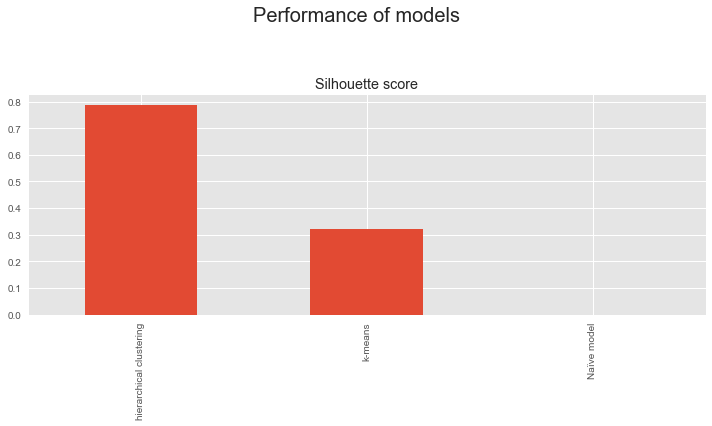

In [1159]:
fig = plt.figure()

# Set properties of the figure
fig.set_figheight(6)
fig.set_figwidth(10)
fig.suptitle('Performance of models\n', fontsize=20)

# Set the geometry of the grid of subplots
gs = gridspec.GridSpec(nrows=1, ncols=1, )

# Initialize axes and set position (left to right, top to bottom)
# Use sharex or sharey parameter for sharing axis
ax1 = fig.add_subplot(gs[0])

# Filling the axes
results_df['Silhouette'].sort_values(ascending=False).T.plot.bar(ax=ax1)

# Rotation of ticks labels
# plt.setp(ax1.get_xticklabels(), rotation='horizontal')
ax1.set_title("Silhouette score")

# Automatically adjusts subplots params to fit the figure
gs.tight_layout(fig, rect=[0, 0, 1, 0.96])

fig.savefig('visualisation/metrics.png')

## **Nombre de clusters** optimal avec chaque algorithme

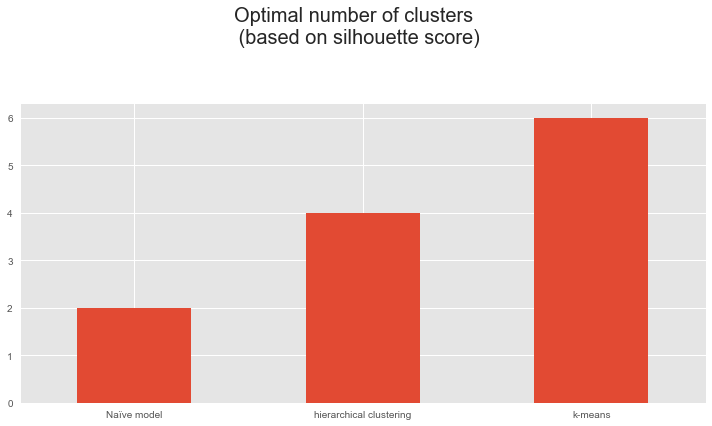

In [1160]:
fig = plt.figure()
# Set properties of the figure
fig.set_figheight(6)
fig.set_figwidth(10)
fig.suptitle(
    'Optimal number of clusters \n (based on silhouette score)',
    fontsize=20
)

# Set the geometry of the grid of subplots
gs = gridspec.GridSpec(nrows=1, ncols=1, )

# Initialize axes and set position (left to right, top to bottom)
# Use sharex or sharey parameter for sharing axis
ax1 = fig.add_subplot(gs[0])

# Filling the axes
results_df['Nb of clusters'].T.plot.bar(ax=ax1)

# Rotation of ticks labels
plt.setp(ax1.get_xticklabels(), rotation='horizontal')

# Automatically adjusts subplots params to fit the figure
gs.tight_layout(fig, rect=[0, 0, 1, 0.9])

fig.savefig('visualisation/nb_clusters.png')

## **Temps** de calcul

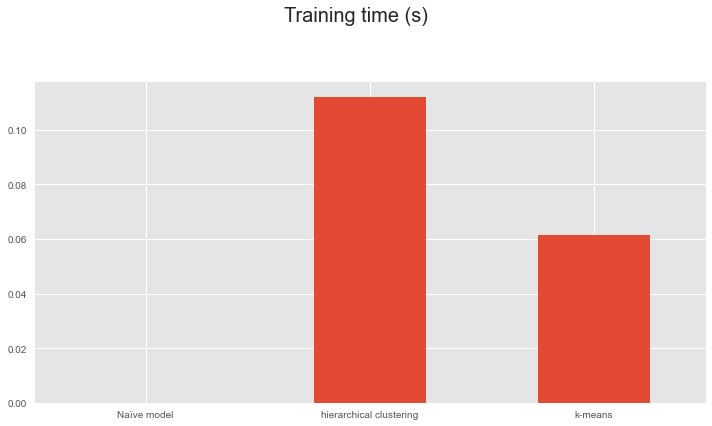

In [1161]:




# Adding the training time to the results DataFrame
results_df.loc['hierarchical clustering', 'Training time (s)'] = hierarchy_search.refit_time_
results_df.loc['k-means', 'Training time (s)'] = kmeans_search.refit_time_

# Set properties of the figure
fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(10)
fig.suptitle('Training time (s)', fontsize=20)

# Set the geometry of the grid of subplots
gs = gridspec.GridSpec(nrows=1, ncols=1, )

# Initialize axes and set position (left to right, top to bottom)
# Use sharex or sharey parameter for sharing axis
ax1 = fig.add_subplot(gs[0])

# Filling the axes
results_df['Training time (s)'].T.plot.bar(ax=ax1)

# Rotation of ticks labels
plt.setp(ax1.get_xticklabels(), rotation='horizontal')

# Automatically adjusts subplots params to fit the figure
gs.tight_layout(fig, rect=[0, 0, 1, 0.9])

fig.savefig('visualisation/training_time.png')

## **Stabilité à l'initialisation** de la partition

### **Indice de Rand Ajusté** (ARI)
L'*Adjusted Rand Index* (ARI) est la normalisation de l'indice de Rand (RI) qui permet de comparer deux partitions de nombres de classes différentes.

$ ARI= \frac{RI-E(RI)}{max(RI)-E(RI)}$
* RI : indice de Rand, proportion de paires de points qui sont groupés de la même façon dans les deux partitions.
* E(RI) : espérance de l'indice de Rand (pour une partition aléatoire)
* max(RI) :indice de Rand maximal qui pourrait être obtenu étant donné le nombre de classes distincts

### Calcul de la métrique de stabilité

In [1162]:


def initialisation_stability(model, nb_iter=5):

    # Creating randomly initialized partitions for comparison
    # --------------------------------------------------------

    # Initializing the list of partitions
    partitions = []

    # Iterating
    for i in range(nb_iter):
        # Fitting the model
        model.fit(X_std)

        # Getting the results (labels of points)
        partitions.append(model.labels_)

    # Computing the ARIscores between partitions
    # --------------------------------------------------------

    # Initializing list of ARIscores
    ARI_scores = []

    # For each partition, except last one
    for i in range(nb_iter - 1):
        # Compute the ARIscore with other partitions
        for j in range(i + 1, nb_iter):
            ARI_score = adjusted_rand_score(partitions[i], partitions[j])
            ARI_scores.append(ARI_score)

    # Compute the mean and standard deviation of ARIscores
    ARI_mean = statistics.mean(ARI_scores)
    ARI_std = statistics.stdev(ARI_scores)

    # Display results
    print(
        "Evaluation of stability upon random initialization:\
        {:.1f}%  ± {:.1f}% ".format(100 * ARI_mean, 100 * ARI_std))

    return ARI_scores


# Computing the metric of stability
print("hierarchy")
stability_hierarchy = initialisation_stability(
    model=hierarchy_search.best_estimator_
)
print("kmeans")
stability_kmeans = initialisation_stability(
    model=kmeans_search.best_estimator_
)


hierarchy
Evaluation of stability upon random initialization:        100.0%  ± 0.0% 
kmeans
Evaluation of stability upon random initialization:        69.7%  ± 11.5% 


### Visualisation

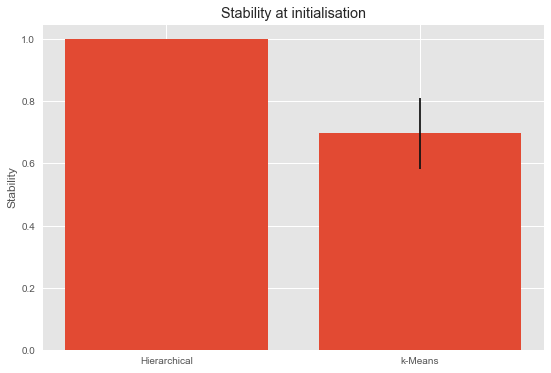

In [1163]:
means = [
    statistics.mean(stability_hierarchy),
    statistics.mean(stability_kmeans),

]

std_errors = [
    statistics.stdev(stability_hierarchy),
    statistics.stdev(stability_kmeans),

]

ind = np.arange(2)  # the x locations for the groups
width = 0.35  # the width of the bars: can also be len(x) sequence

plt.bar(ind, means, yerr=std_errors)

plt.ylabel('Stability')
plt.title('Stability at initialisation')
plt.xticks(ind, ('Hierarchical', 'k-Means'))

plt.show()





In [1164]:

# Get initial data about customers
data_customers = pd.read_csv("data\cleaned_p5_data_PCA.csv")

# Sampling
data_customers = data_customers.sample(n=2000, random_state=seed)
data_customers = data_customers.reset_index()

# Get the data about customers, before PCA
data_encoded = pd.read_csv("data/df_clean_part_time.csv")

In [1165]:
data_encoded.head(2)

,customer_unique_id,order_purchase_timestamp,payment_type,payment_sequential_mean,payment_installments_mean,review_score_mean,distance_seller_customer_km,customer_geolocation_region,product_volume_cm3,total_price
0,861eff4711a542e4b93843c6dd7febb0,1494947135000000000,credit_card,1.0,2.0,4.0,346.491931,Southeast,107136.0,146.87
1,290c77bc529b7ac935b93aa66c333dc3,1494947135000000000,credit_card,1.0,8.0,5.0,347.800921,Southeast,53400.0,335.48


In [1166]:
# Get the 'timestamps' of orders
data_timestamps = pd.to_datetime(data_encoded['order_purchase_timestamp'])

# Apply the same sampling as data_customers

mask = data_timestamps.index.isin(data_customers.index)
data_timestamps = data_timestamps[mask]

In [1167]:
date_min = data_timestamps.min()
date_max = data_timestamps.max()
duration = date_max - date_min

print('The data set covers a period of {} days, from {} to {}.'
      .format(duration.days, date_min.date(), date_max.date()))

The data set covers a period of 438 days, from 2017-05-16 to 2018-07-29.


## Évaluation de la stabilité temporelle

In [1168]:


def time_stability(model, nb_iter=5, init_centroid=False):


    print("date_min",date_min)
    date_init = date_min + timedelta(days=105)
    print("timest",data_timestamps)
    # Getting the initial data set
    timemask = (data_timestamps < date_init)
    X_init = data_customers[timemask]

    # Standardization
    X_init_std = X_init

    # Fitting the model on intial data
    model.fit(X_init_std)

    # Predicting the initial clusters labels for initial customers
    clusters_init = model.labels_

    if init_centroid == True:
        # Save the centroids for further initialisations
        cluster_centers = model.cluster_centers_

    # Initializations
    ARI_results = pd.DataFrame()
    index = -1
    date_lim = date_init
    print('init',date_init)
    # Iterating until we reach the maximum date in data set
    while date_lim < date_max:
        index += 1
        # getting the new data truncated
        timemask = (data_timestamps < date_lim)

        X_trunc = data_customers[timemask]

        #standardisation and PCA
        X_trunc_std = X_trunc

        # iterating for stability and standard deviation of scores
        # --------------------------------------------------------
        ARI_scores = []

        for i in range(nb_iter):

            # From 1st month, set the initial centroids
            if index == 1 & init_centroid == True:
                model.set_params(init=cluster_centers, n_init=1, random_state=None)

            # fitting a new model on the truncated data
            model.fit(X_trunc_std)

            # Creating a mask for customers in initial partition
            list_init = X_init_std.index
            mask = X_trunc_std.index.isin(list_init)

            # Getting the labels for the initial customers
            clusters_new = model.labels_[mask]

            # Computing and saving ARI score between initial clustering and new ones
            ARI_score = adjusted_rand_score(clusters_init, clusters_new)
            ARI_scores.append(ARI_score)

            # Add timestamp and ARI scores to the results pd.DataFrame
            ARI_results.loc[index, 'period'] = date_lim  #- date_init
            ARI_results.loc[index, 'ARI_score_mean'] = np.mean(ARI_scores)
            ARI_results.loc[index, 'ARI_score_std'] = np.std(ARI_scores)

        # increase timelimit by 30 days for next iteration
        date_lim += timedelta(days=30)

    return ARI_results

In [1169]:


# Initialising with random seed
kmeans_search.best_estimator_.set_params(init='k-means++', random_state=seed)

# Getting results of time stability for each model
hierarchy_stability = time_stability(model=hierarchy_search.best_estimator_)
kmeans_stability = time_stability(
    model=kmeans_search.best_estimator_,
    init_centroid=True
)

# Setting back the kmeans_search
kmeans_search.best_estimator_.set_params(init='k-means++', random_state=seed)

date_min 2017-05-16 15:05:35
timest 0      2017-05-16 15:05:35
1      2017-05-16 15:05:35
2      2017-05-16 15:05:35
3      2017-05-16 15:05:35
4      2017-05-16 15:05:35
               ...        
1995   2017-11-27 17:23:20
1996   2017-11-27 17:23:20
1997   2017-11-27 17:23:20
1998   2017-11-27 17:23:20
1999   2017-11-27 17:23:20
Name: order_purchase_timestamp, Length: 2000, dtype: datetime64[ns]
init 2017-08-29 15:05:35
date_min 2017-05-16 15:05:35
timest 0      2017-05-16 15:05:35
1      2017-05-16 15:05:35
2      2017-05-16 15:05:35
3      2017-05-16 15:05:35
4      2017-05-16 15:05:35
               ...        
1995   2017-11-27 17:23:20
1996   2017-11-27 17:23:20
1997   2017-11-27 17:23:20
1998   2017-11-27 17:23:20
1999   2017-11-27 17:23:20
Name: order_purchase_timestamp, Length: 2000, dtype: datetime64[ns]
init 2017-08-29 15:05:35


MiniBatchKMeans(n_init=1, random_state=597)

## **Visualisation** de l'évolution du modèle de partitionnement


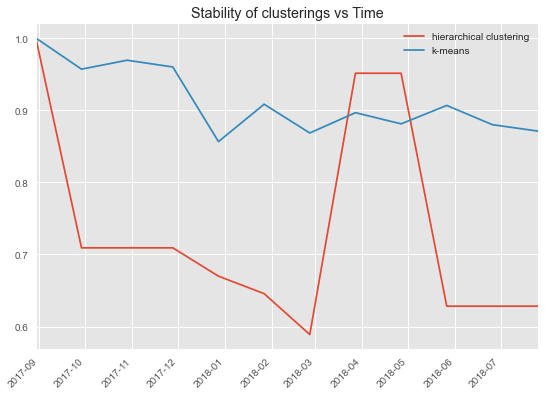

<Figure size 648x432 with 0 Axes>

In [1170]:


x = hierarchy_stability['period']
plt.plot(
    x,
    hierarchy_stability['ARI_score_mean'],
    label='hierarchical clustering'
)
plt.plot(x, kmeans_stability['ARI_score_mean'], label='k-means')
plt.xlim(hierarchy_stability['period'][0], hierarchy_stability['period'][11])
plt.legend()
plt.title("Stability of clusterings vs Time")
plt.xticks(rotation='45', horizontalalignment="right")
plt.show()
fig = plt.figure()
fig.savefig('visualisation/stability.png')


Strategie d'ajout nouveau dataset





In [1171]:
plt.figure()
clusters = model.labels_
X_std = data_PCA
pca = decomposition.PCA(n_components=2).fit(X_std)
X_projected = pca.transform(X_std)
model_kmean.fit(X_std)
centroids = model_kmean.cluster_centers_




<Figure size 648x432 with 0 Axes>

In [1172]:
centroids_projected = pca.transform(centroids)



In [1173]:
centroids_projected

ref_cluster = pd.DataFrame(centroids_projected,
                           columns=['x1', 'x2'])


In [1174]:
ref_cluster['Cluster Labels'] = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', ]

use of predict method to point out closest cluster for the unseen data
Utilisation de la methode predict pour récupérer les clusters les plus proches

In [1175]:
#get train data
X_std_sample = data_PCA.sample(n=1000, random_state=seed)
standardized_features = X_std_sample

In [1176]:
X_std_sample_tr = model_kmean.transform(X_std_sample)
model_kmean.fit(X_std_sample_tr)
predicted_X_std_sample = model_kmean.predict(X_std_sample_tr)

on a donc pour chaque ligne le cluster plus proche pour l'ajout de nouvelle donnée en utilisant la
methode predict de kmean


In [1177]:

New_Radar_cluster = pd.DataFrame(predicted_X_std_sample,
                                 columns=['Cluster Labels'])


In [1178]:
New_Radar_cluster['Segment'] = New_Radar_cluster['Cluster Labels'].map({0: 'Cluster 1', 1: 'Cluster 2',
                                                                        2: 'Cluster 3', 3: 'Cluster 4',
                                                                        4: 'Cluster 5', 5: 'Cluster 6', })

New_Radar_cluster



,Cluster Labels,Segment
0,3,Cluster 4
1,5,Cluster 6
2,4,Cluster 5
3,3,Cluster 4
4,5,Cluster 6
...,...,...
995,0,Cluster 1
996,4,Cluster 5
997,3,Cluster 4
998,1,Cluster 2


In [1179]:
# Getting the original standardized features for customers
standardized_features = pd.read_csv("data\cleaned_p5_data_std.csv")

In [1180]:
# Creating a mask for the sample
mask = standardized_features.index.isin(X_std_sample.index)

# Keeping data only for the sample
New_standardized_features = standardized_features[mask]
New_standardized_features.head(2)

,payment_sequential_mean,payment_installments_mean,review_score_mean,distance_seller_customer_km,product_volume_cm3,total_price,payment_type_credit_card,customer_geolocation_region_Southeast
0,-0.12058,-0.336493,-0.050546,-0.171440,3.953368,0.001150,0.586052,0.004633
53,-0.12058,-0.709891,0.687897,-0.170323,-0.312109,-0.375422,0.586052,0.004633


Liaison de chaque ligne du dataset et son cluster

In [1181]:
#Get new index from sample
new_index = New_standardized_features.index
#set the new index to the dataset
New_Radar_cluster = New_Radar_cluster.set_index(new_index)
New_Radar_cluster.head(5)



,Cluster Labels,Segment
0,3,Cluster 4
53,5,Cluster 6
113,4,Cluster 5
208,3,Cluster 4
251,5,Cluster 6


In [1182]:
New_Radar_cluster = New_standardized_features.join(New_Radar_cluster)
New_Radar_cluster

,payment_sequential_mean,payment_installments_mean,review_score_mean,distance_seller_customer_km,product_volume_cm3,total_price,payment_type_credit_card,customer_geolocation_region_Southeast,Cluster Labels,Segment
0,-0.12058,-0.336493,-0.050546,-0.171440,3.953368,0.001150,0.586052,0.004633,3,Cluster 4
53,-0.12058,-0.709891,0.687897,-0.170323,-0.312109,-0.375422,0.586052,0.004633,5,Cluster 6
113,-0.12058,-0.709891,-1.281283,-0.168905,-0.505930,-0.468240,0.586052,0.004633,4,Cluster 5
208,-0.12058,-0.709891,-0.788988,-0.951965,0.184858,0.053338,0.586052,0.004633,3,Cluster 4
251,-0.12058,-0.709891,-0.050546,-0.947905,0.509432,0.521364,0.586052,0.004633,5,Cluster 6
...,...,...,...,...,...,...,...,...,...,...
92519,-0.12058,-0.709891,-0.050546,-0.134582,0.432417,-0.270692,0.586052,0.004633,0,Cluster 1
92742,-0.12058,2.650690,-0.050546,0.268576,1.552344,0.209750,0.586052,0.004633,4,Cluster 5
92848,-0.12058,-0.709891,0.687897,0.262982,-0.309615,-0.268673,0.586052,0.004633,3,Cluster 4
92867,-0.12058,5.637873,0.687897,0.263257,-0.607184,0.224337,0.586052,0.004633,1,Cluster 2


ajout nouveau dataset dans l'ancien avec les cluster identifié

In [1183]:
updated_Radar_Cluster = pd.concat([Ref_Radar_cluster, New_Radar_cluster])
updated_Radar_Cluster

,payment_sequential_mean,payment_installments_mean,review_score_mean,distance_seller_customer_km,product_volume_cm3,total_price,payment_type_credit_card,customer_geolocation_region_Southeast,Cluster Labels,Segment
0,1.00000,2.000000,4.000000,346.491931,107136.000000,146.870000,1.000000,1.000000,3,Cluster 4
1,1.00000,8.000000,5.000000,347.800921,53400.000000,335.480000,1.000000,1.000000,5,Cluster 6
2,1.00000,7.000000,5.000000,346.440279,45968.000000,157.730000,1.000000,1.000000,5,Cluster 6
3,1.00000,1.000000,5.000000,349.408210,79968.000000,173.300000,1.000000,1.000000,3,Cluster 4
4,1.00000,8.000000,5.000000,345.410141,23625.000000,252.250000,1.000000,1.000000,0,Cluster 1
...,...,...,...,...,...,...,...,...,...,...
92519,-0.12058,-0.709891,-0.050546,-0.134582,0.432417,-0.270692,0.586052,0.004633,0,Cluster 1
92742,-0.12058,2.650690,-0.050546,0.268576,1.552344,0.209750,0.586052,0.004633,4,Cluster 5
92848,-0.12058,-0.709891,0.687897,0.262982,-0.309615,-0.268673,0.586052,0.004633,3,Cluster 4
92867,-0.12058,5.637873,0.687897,0.263257,-0.607184,0.224337,0.586052,0.004633,1,Cluster 2


In [1184]:
df_rich = Ref_Radar_cluster[Ref_Radar_cluster['Cluster Labels'] == 4]

df_rich

,payment_sequential_mean,payment_installments_mean,review_score_mean,distance_seller_customer_km,product_volume_cm3,total_price,payment_type_credit_card,customer_geolocation_region_Southeast,Cluster Labels,Segment
5,1.0,1.0,5.0,346.373294,7280.734746,282.912963,1,1,4,Cluster 5
9,1.0,1.0,5.0,346.344348,12000.000000,122.470000,1,1,4,Cluster 5
10,1.0,1.0,5.0,349.273261,14229.000000,40.400000,1,1,4,Cluster 5
11,1.0,1.0,5.0,349.071446,8100.000000,153.130000,1,1,4,Cluster 5
13,1.0,6.5,4.0,345.896197,8352.000000,140.750000,1,1,4,Cluster 5
...,...,...,...,...,...,...,...,...,...,...
93150,1.5,3.0,1.0,378.500232,13860.000000,199.920000,1,1,4,Cluster 5
93152,1.0,1.0,5.0,366.867894,10500.000000,63.730000,1,1,4,Cluster 5
93157,1.0,6.0,4.0,368.133335,11132.000000,88.780000,1,1,4,Cluster 5
93158,1.0,3.0,5.0,370.600934,13200.000000,129.060000,1,1,4,Cluster 5


In [1185]:
full_df_a = pd.read_pickle("data/df_clean_part1")
full_df_a

,customer_unique_id,frequency,payment_type,recency_mean,payment_sequential_mean,payment_installments_mean,review_score_mean,distance_seller_customer_km,customer_geolocation_region,main_category,product_volume_cm3,total_price
0,861eff4711a542e4b93843c6dd7febb0,147.0,credit_card,519.0,1.0,2.0,4.0,346.491931,Southeast,furniture,107136.0,146.87
1,290c77bc529b7ac935b93aa66c333dc3,178.0,credit_card,277.0,1.0,8.0,5.0,347.800921,Southeast,furniture,53400.0,335.48
2,060e732b5b29e8181a18229c7b0b2b5e,103.0,credit_card,151.0,1.0,7.0,5.0,346.440279,Southeast,furniture,45968.0,157.73
3,259dac757896d24d7702b9acbbff3f3c,133.0,credit_card,218.0,1.0,1.0,5.0,349.408210,Southeast,furniture,79968.0,173.30
4,345ecd01c38d18a9036ed96c73b8d066,157.0,credit_card,80.0,1.0,8.0,5.0,345.410141,Southeast,furniture,23625.0,252.25
...,...,...,...,...,...,...,...,...,...,...,...,...
96091,1a29b476fee25c95fbafc67c5ac95cf8,49.0,credit_card,193.0,1.0,6.0,4.0,368.133335,Southeast,construction,11132.0,88.78
96092,d52a67c98be1cf6a5c84435bd38d095d,211.0,credit_card,196.0,1.0,3.0,5.0,370.600934,Southeast,construction,13200.0,129.06
96093,e9f50caf99f032f0bf3c55141f019d99,157.0,credit_card,191.0,1.0,5.0,1.0,377.888773,Southeast,construction,9000.0,56.04
96094,73c2643a0a458b49f58cea58833b192e,137.0,credit_card,347.0,1.0,2.0,5.0,388.960615,Southeast,construction,3458.0,711.07


In [1186]:
full_df = full_df_a
new_index = Ref_Radar_cluster.index
full_df = full_df.set_index(new_index)
df_rich['main_category'] = full_df['main_category']

<ipython-input-1186-270942825b84>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [1187]:
df_rich



,payment_sequential_mean,payment_installments_mean,review_score_mean,distance_seller_customer_km,product_volume_cm3,total_price,payment_type_credit_card,customer_geolocation_region_Southeast,Cluster Labels,Segment,main_category
5,1.0,1.0,5.0,346.373294,7280.734746,282.912963,1,1,4,Cluster 5,furniture
9,1.0,1.0,5.0,346.344348,12000.000000,122.470000,1,1,4,Cluster 5,furniture
10,1.0,1.0,5.0,349.273261,14229.000000,40.400000,1,1,4,Cluster 5,furniture
11,1.0,1.0,5.0,349.071446,8100.000000,153.130000,1,1,4,Cluster 5,furniture
13,1.0,6.5,4.0,345.896197,8352.000000,140.750000,1,1,4,Cluster 5,furniture
...,...,...,...,...,...,...,...,...,...,...,...
93150,1.5,3.0,1.0,378.500232,13860.000000,199.920000,1,1,4,Cluster 5,construction
93152,1.0,1.0,5.0,366.867894,10500.000000,63.730000,1,1,4,Cluster 5,construction
93157,1.0,6.0,4.0,368.133335,11132.000000,88.780000,1,1,4,Cluster 5,construction
93158,1.0,3.0,5.0,370.600934,13200.000000,129.060000,1,1,4,Cluster 5,construction


In [1188]:
df_loyal_count = pd.DataFrame({'main_category': df_rich['main_category'].value_counts().head(10).index,
                               'nombre': df_rich['main_category'].value_counts().head(10).values})
df_loyal_count

,main_category,nombre
0,furniture,5430
1,health_beauty,3610
2,home,3012
3,leisure,2684
4,multimedia,2055
5,gifts,1994
6,supplies,1865
7,construction,1144
8,fashion,412
9,misc,334


In [1189]:


fig_1 = px.histogram(df_loyal_count,
                     title="Produit les plus acheter par les clients fidèle",
                     x="main_category",
                     y='nombre',

                     color="main_category",
                     color_discrete_sequence=px.colors.qualitative.Pastel2,
                     barmode="group"

                     ).update_xaxes(categoryorder="total ascending")

fig_1.show()

In [1190]:
full_df = full_df_a
df_mean = Ref_Radar_cluster[Ref_Radar_cluster['Cluster Labels'] == 3]

new_index = Ref_Radar_cluster.index
full_df = full_df.set_index(new_index)
df_mean['main_category'] = full_df['main_category']

<ipython-input-1190-20ed078c3e2d>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [1191]:
df_mean_count = pd.DataFrame({'main_category': df_mean['main_category'].value_counts().head(10).index,
                              'nombre': df_mean['main_category'].value_counts().head(10).values})
df_mean_count

,main_category,nombre
0,furniture,479
1,health_beauty,319
2,leisure,265
3,home,243
4,multimedia,185
5,gifts,180
6,supplies,167
7,construction,96
8,fashion,43
9,misc,30


In [1192]:

fig_1 = px.histogram(df_mean_count,
                     title="Produit les plus acheter par les clients les moins satisfait",
                     x="main_category",
                     y='nombre',

                     color="main_category",
                     color_discrete_sequence=px.colors.qualitative.Pastel2,
                     barmode="group"

                     ).update_xaxes(categoryorder="total ascending")

fig_1.show()